# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as a Jupyter notebook document. Before exporting the notebook to ipynb, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> Notebook (.ipynb)**. Include the finished document along with this notebook as your submission. 


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive') # You can either use your drive or work directly on colab with temporary import

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#@title Run Me Please
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
# import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow import keras
# try:
#   tf.enable_eager_execution()
#   print('Running in Eager mode.')
# except ValueError:
#   print('Already running in Eager mode')


In [6]:
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.inception_v3 import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
#from tensorflow.contrib.layers import flatten

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
from sklearn.utils import shuffle

# Feel free to import more packages


---
## Step 0: Load The Data

In [7]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
# If you have a folder in your Drive named traffic-signs-data you do so, else change directory

training_file = '/content/gdrive/My Drive/traffic-signs-data/train.p'
validation_file= '/content/gdrive/My Drive/traffic-signs-data/valid.p'
testing_file = '/content/gdrive/My Drive/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [8]:
# Please complete None with your code
#-------------------------------------------------------------------------
import pandas as pd
signs = []
signnames = pd.read_csv('/content/gdrive/My Drive/traffic-signs-data/signnames.csv', delimiter=',', header=0)
for row in range(signnames.shape[0]):
     signs.append(signnames.iloc[row, 1])    
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [9]:
# Please complete None with your code
#-------------------------------------------------------------------------
#  Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = np.shape(X_valid)[0]

# Number of test examples.
n_test = np.shape(X_test)[0]

#  What's the shape of a traffic sign image?
image_shape = X_test[0].shape

#  How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of valid examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Number of valid examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [10]:
# In this part you should One-hot encode all Y-s vectors using
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['labels'])
train_labels_enc = le.transform(train['labels'])
validation_labels_enc = le.transform(valid['labels'])

In [11]:
from tensorflow.keras.utils import to_categorical
encoded = to_categorical(y_train)
test_encoded  = to_categorical(y_test)
print(encoded.shape)

(34799, 43)


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

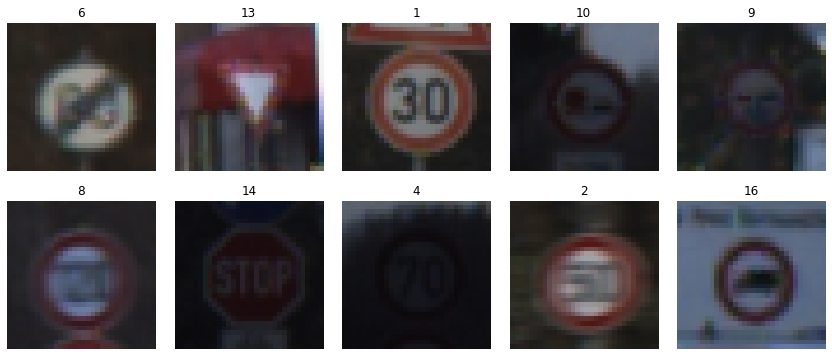

In [12]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
def show_images(X,Y,r,c):
  fig, axs = plt.subplots(r,c, figsize=(15, 6))
  fig.subplots_adjust(hspace = .2, wspace=.001)
  axs = axs.ravel()
  for i in range(r*c): # if rows = 2 and columns = 5 i should take 10 values
      index = np.random.randint(0, len(X))
      image = X[index]
      axs[i].axis('off')
      axs[i].imshow(image)
      axs[i].set_title(Y[index])
  plt.show()    

# show image of 10 random data points
rows = 2
columns = 5
show_images (X_train,y_train,rows,columns)

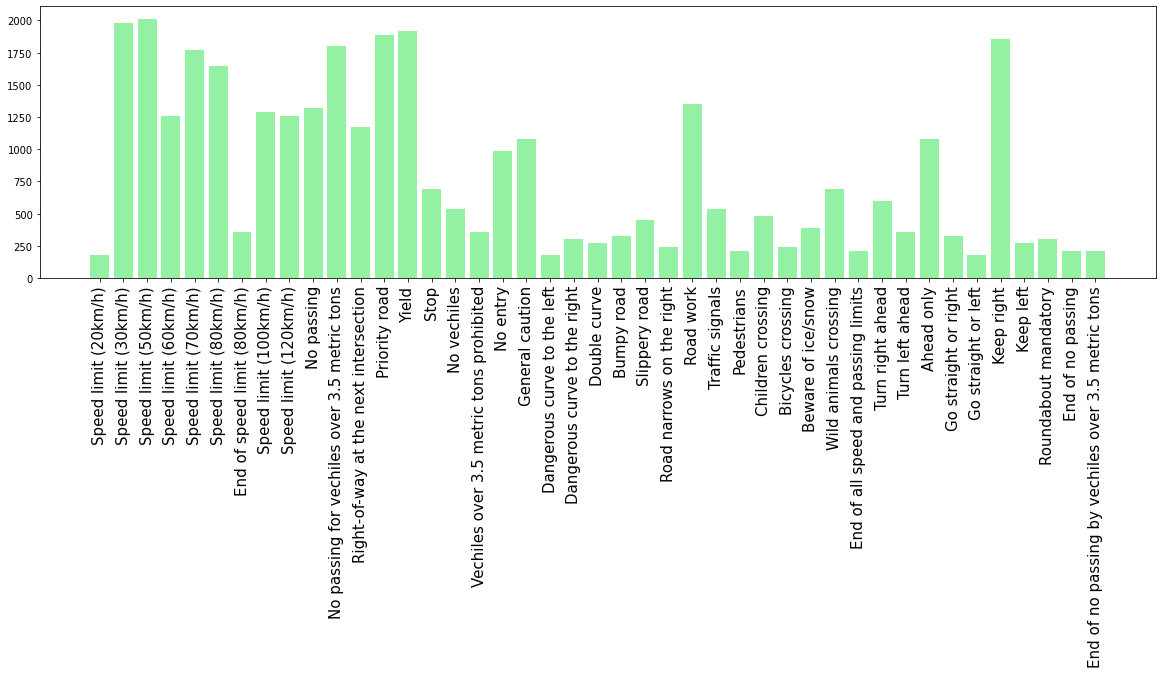

In [13]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_train, return_counts=True)
#names is a list of traffic signs, Remember that we already have a list : signs
names = signs 
y_pos = np.arange(len(names))
plt.bar(item, count, alpha=0.6, color = (0.3,0.9,0.4,0.6) )

plt.xticks(y_pos, names, fontsize=15, rotation=90)

plt.show()

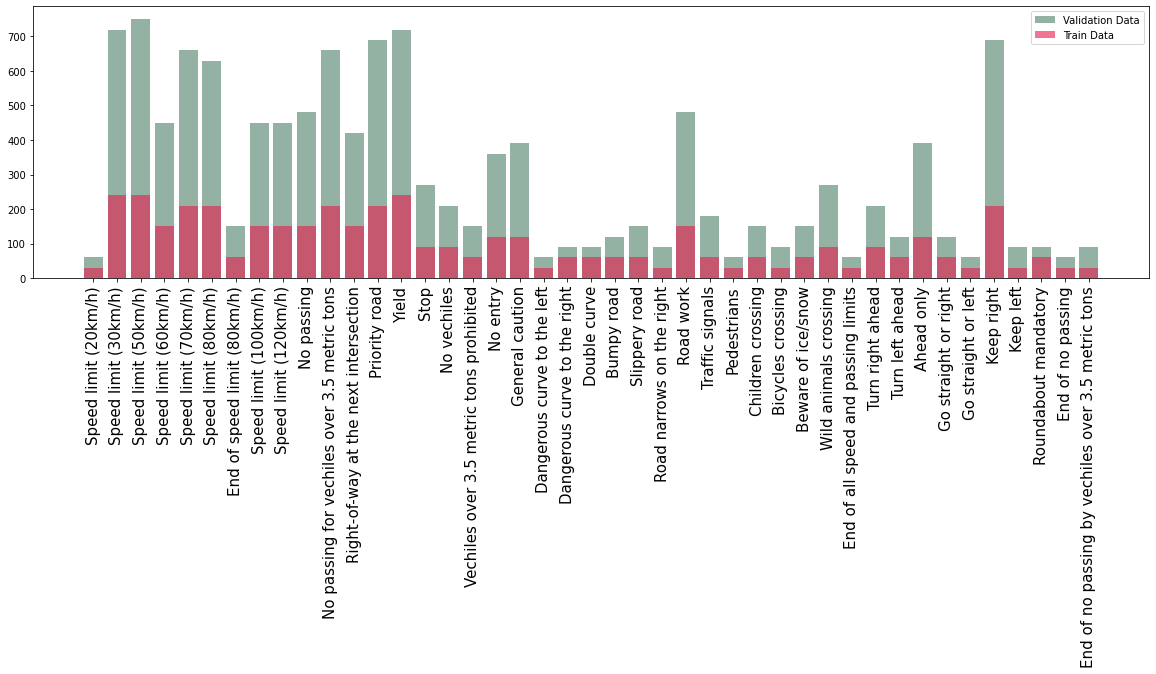

In [14]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_test, return_counts=True)
item1, count1 = np.unique(y_valid, return_counts=True)

names = signs
#names1 = None

y_pos = np.arange(len(names))
plt.bar(item, count, alpha=0.6, color = (0.3,0.5,0.4,0.2), label="Validation Data" )

plt.bar(item1, count1, alpha=0.6, color = (0.9,0.1,0.3,0.2), label="Train Data" )

plt.xticks(y_pos, names, fontsize=15, rotation=90)
plt.legend()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [15]:
# gray scale
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gry = np.sum(X_valid/3, axis=3, keepdims=True)

In [16]:
X_train_orig = X_train
X_test_orig = X_test
#Standardization 
X_train_std = (X_train - X_train.mean()) / np.std(X_train)
X_test_std = (X_test - X_test.mean()) /np.std(X_test)
# normalization Here 
X_train_norm = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test_norm = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


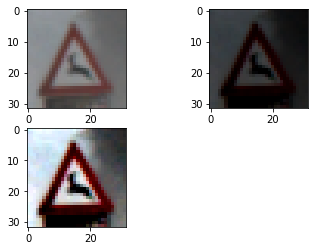

In [17]:
#plotting normalized images
plt.subplot(2,2,1)
plt.imshow(X_train_orig[555])
plt.subplot(2,2,2)
plt.imshow(X_train_norm[555])
plt.subplot(2,2,3)
plt.imshow(X_train_std[555])

In [18]:
# Implement Min-Max scaling for image data
def normalize(image_data):
    a = 0.01
    b = 0.99
    color_min = 0.0
    color_max = 255.0
    return a + ( ( (image_data - color_min) * (b - a) )/(color_max - color_min))

# Normalize train features and test features
X_train = normalize(X_train)
X_test = normalize(X_test)

In [19]:
# Shuffle your data here 
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [20]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

Next cells should be useful for data augmentation

In [21]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

In [22]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

In [23]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

In [56]:
# Data augmentation 
# This may take too much time...
# i've set 2000 as a minimum number of images for each class
# if u don't already have a file containing generated Data, Run ME please
# --------------------------!!!!-----------------------------------------

# input_indices = []
# output_indices = []
# new_X_train = ()

# for class_n in range(n_classes):
#     class_indices = np.where(y_train == class_n)
#     n_samples = len(class_indices[0])
#     if n_samples < 2000:
#         for i in range(2000 - n_samples):
#             input_indices.append(class_indices[0][i%n_samples])
#             output_indices.append(new_X_train.shape[0])
#             new_img = new_X_train[class_indices[0][i % n_samples]]
#             new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
#             new_X_train = np.concatenate((new_X_train, [new_img]), axis=0)
#             y_train = np.concatenate((y_train, [class_n]), axis=0)
# data_file = "/content/gdrive/My Drive/traffic-signs-data/new_train.p"
# pickle.dump({"images":new_X_train,"labels":y_train},open(data_file,"wb"),protocol=4)

In [58]:
# if u do have a file that contains new_train data RUN ME
# with open("/content/gdrive/My Drive/traffic-signs-data/new_train.p","rb") as f:
#     data = pickle.load(f)
# new_X_train,y_train = data["images"],data["labels"]


In [24]:
# shuffle data  
X_train, y_train = shuffle(X_train, y_train)

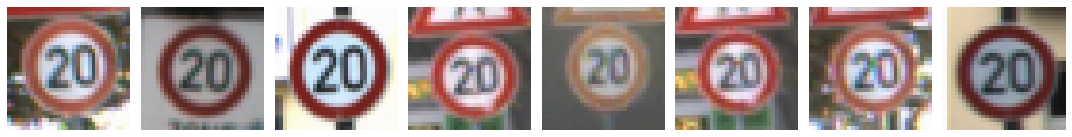

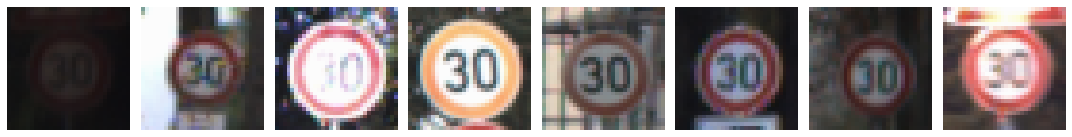

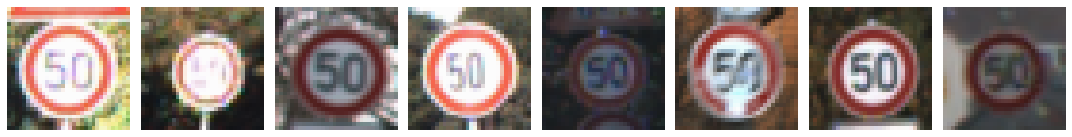

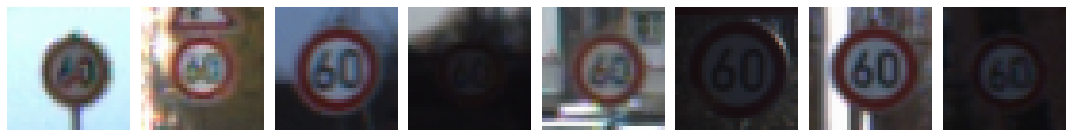

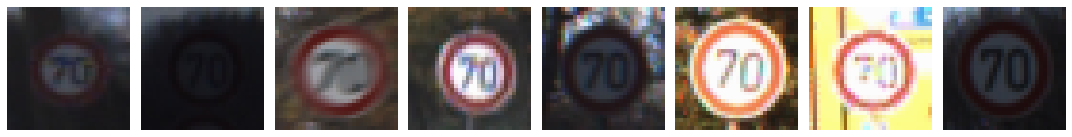

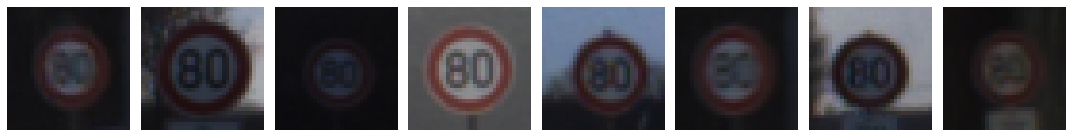

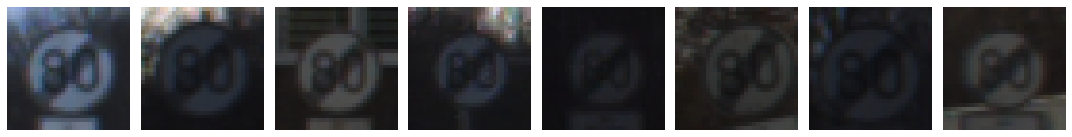

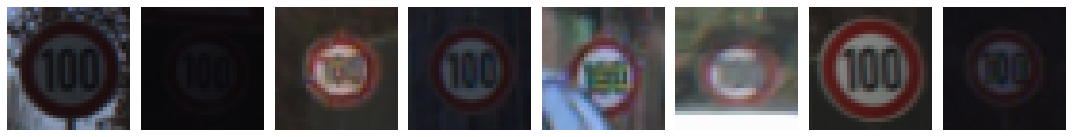

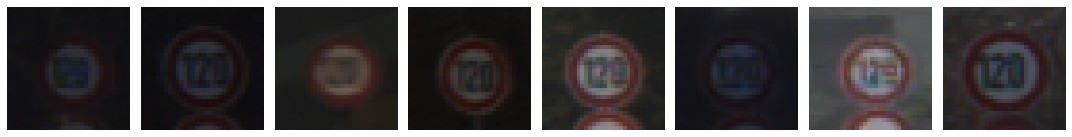

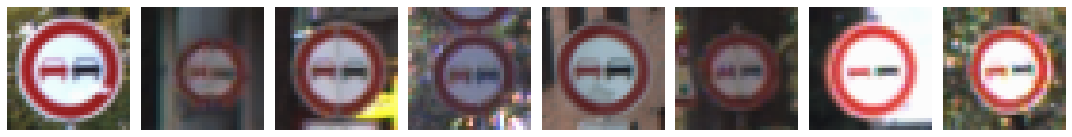

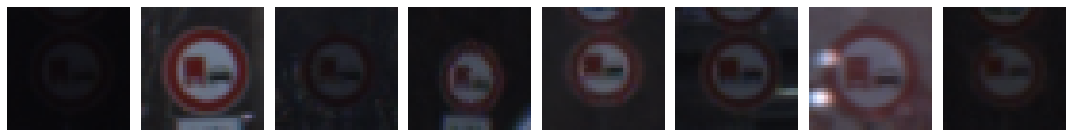

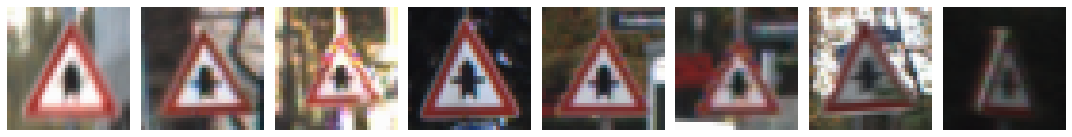

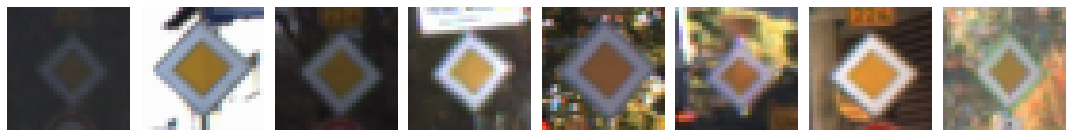

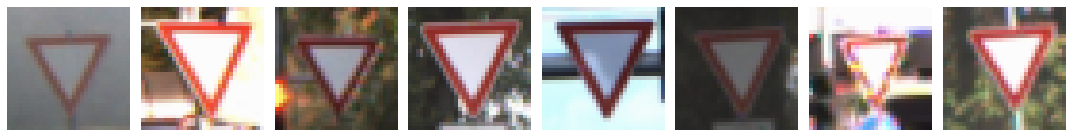

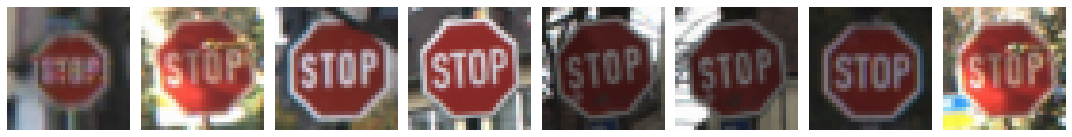

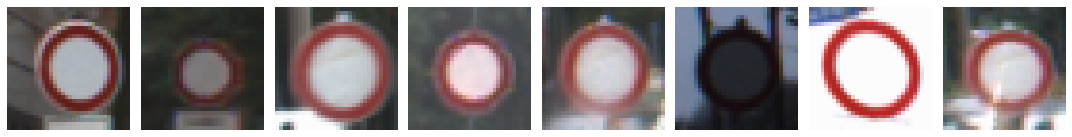

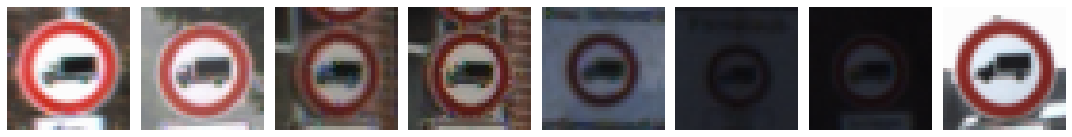

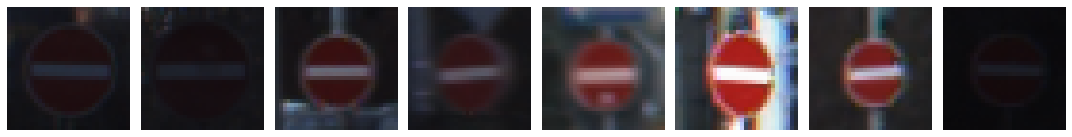

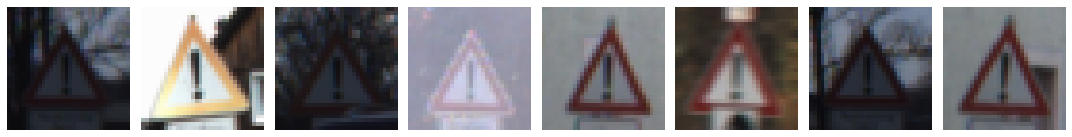

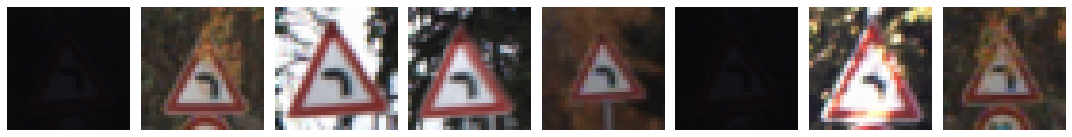

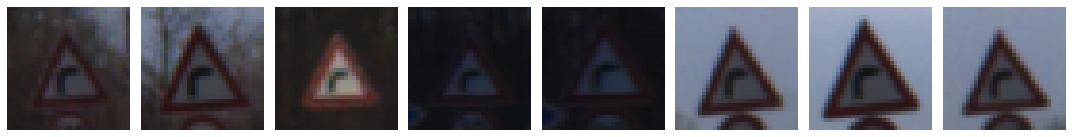

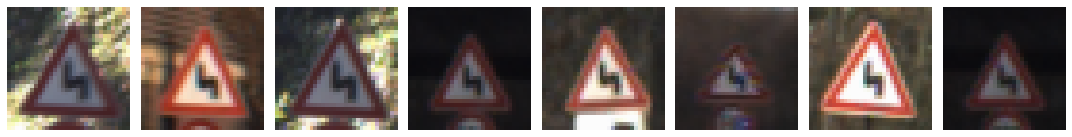

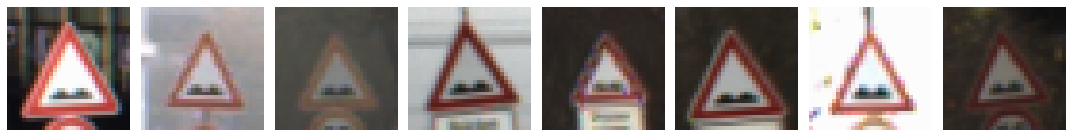

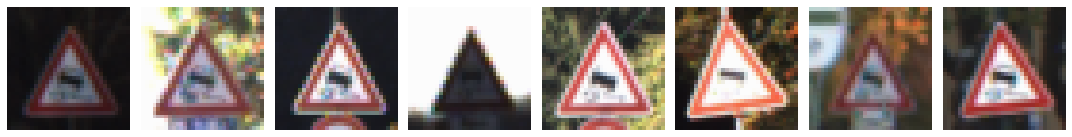

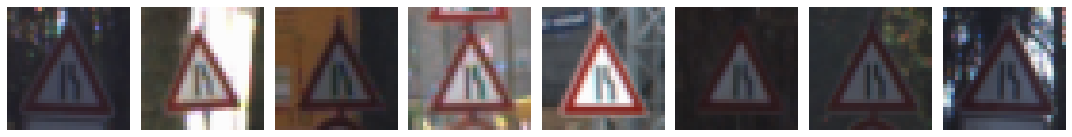

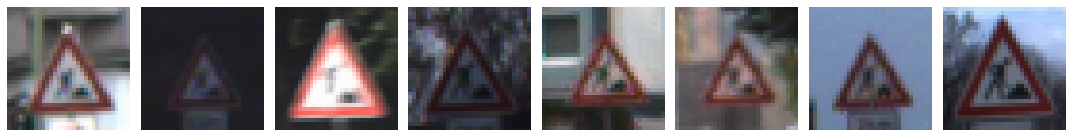

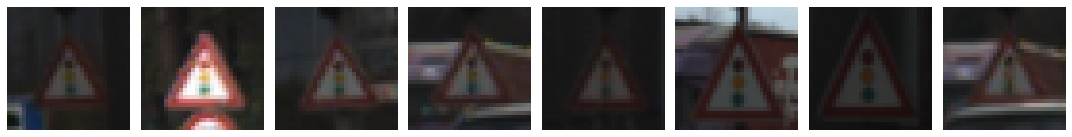

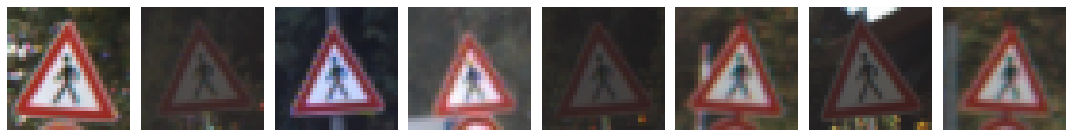

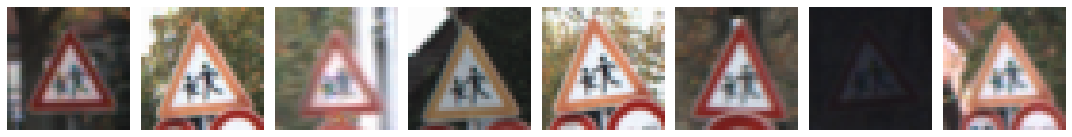

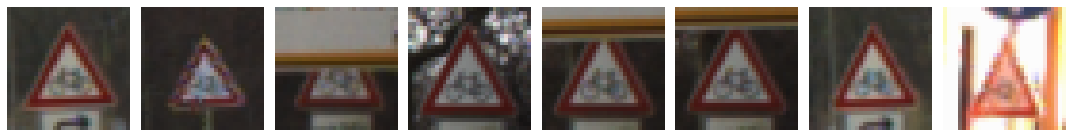

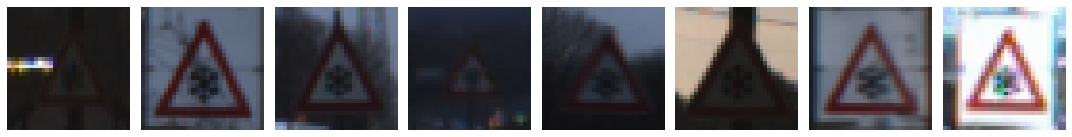

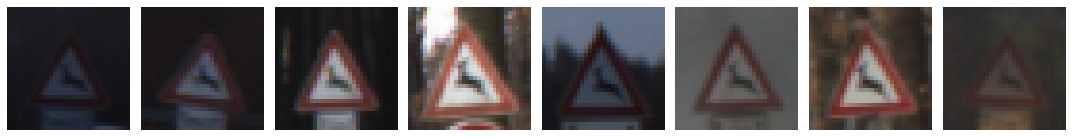

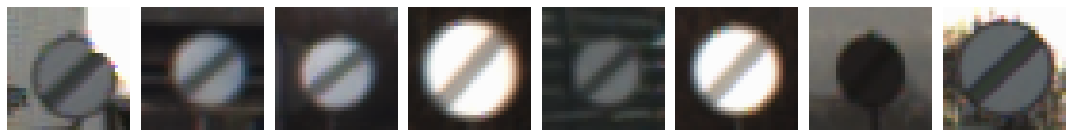

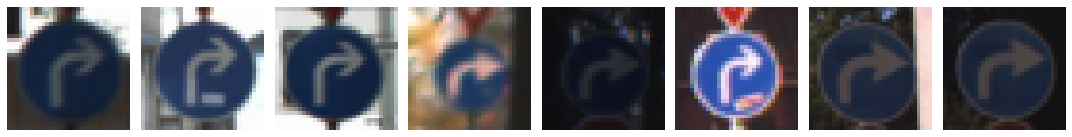

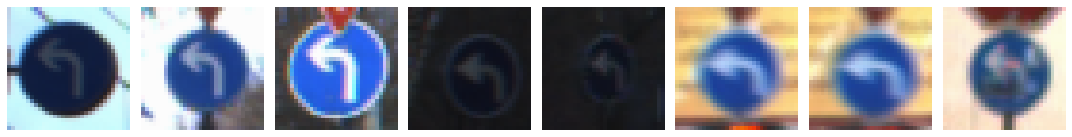

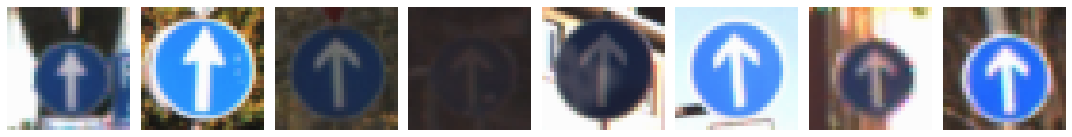

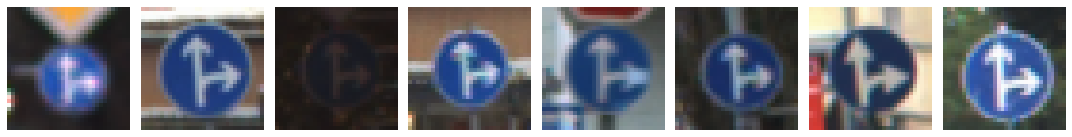

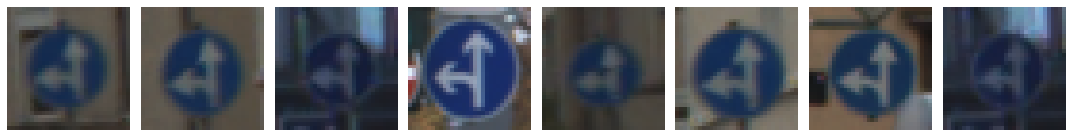

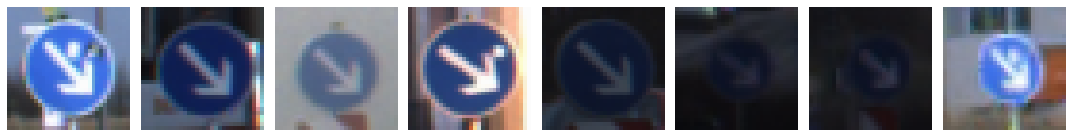

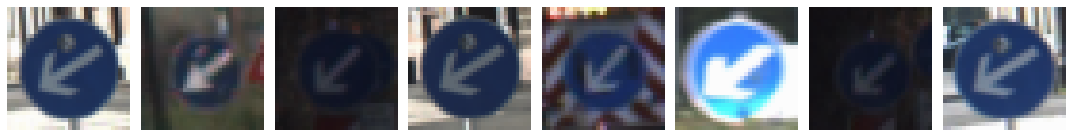

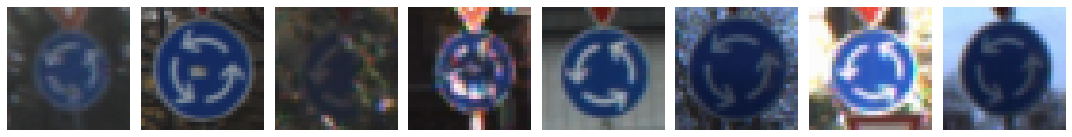

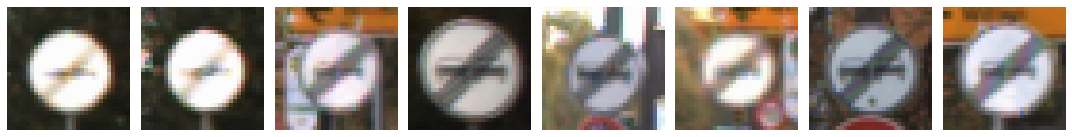

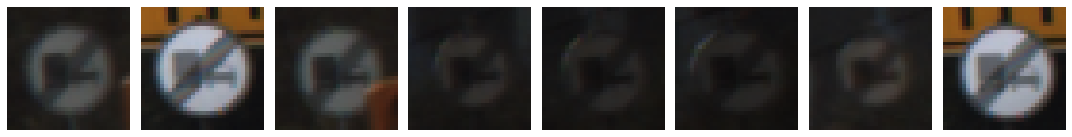

In [25]:
def plot_figures_no_labels(figures, nrows = 1, ncols=1):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        axs[index].set_axis_off()
        
    plt.tight_layout()
    plt.show()
    
for class_n in range(n_classes): # you should range for all classes 
  figures = {}

  class_indices = list (np.where(y_train == class_n)[0])
  
  for i in range(8):
    
        figures[i] = X_train[class_indices[-i]].squeeze()
      
  plot_figures_no_labels(figures, 1, 8)

      


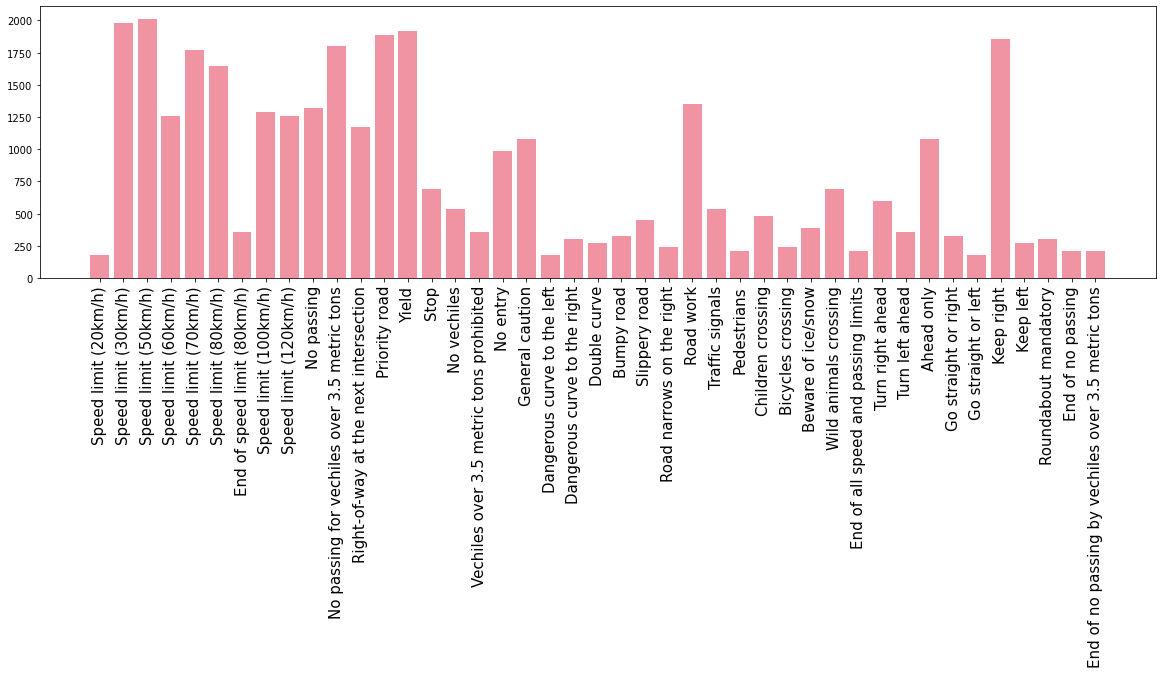

In [26]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_train, return_counts=True)
names = signs
y_pos = np.arange(len(names))
plt.bar(item, count, alpha=0.6, color = (0.9,0.3,0.4,0.6) )
plt.xticks(y_pos, names, fontsize=15, rotation=90)
plt.show()

### Model Architecture

In [45]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

In [37]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [46]:
IMAGE_SIZE = [32, 32]
epochs = 100
batch_size = 64
image_input = Input(shape=(32, 32, 1))


In [47]:
# define your model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
np.random.seed(0)

def neural_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation = 'softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model
# Use pretrained model 
model = neural_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 480)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train, Validate and Test the Model

In [52]:
#Training
# fit model
history = model.fit(train['features'],train['labels'], epochs = 10, 
                 validation_data =(test['features'], test['labels'])) 

In [52]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(history.history['val_acc'], label='Validation accuracy', color = palette(2))
plt.plot(history.history['acc'], label='Train accuracy', color = palette(1))
plt.title("Training Performance")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [52]:
# Test
# Can you do better than me?   
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape) 
#we will include weights learned with imagenet dataset
output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(vgg.input, output)
# we can chose which layer to train 
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
# all layers are not trainable

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from sklearn.metrics import confusion_matrix

predicted_classes = None
y_true = None

cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

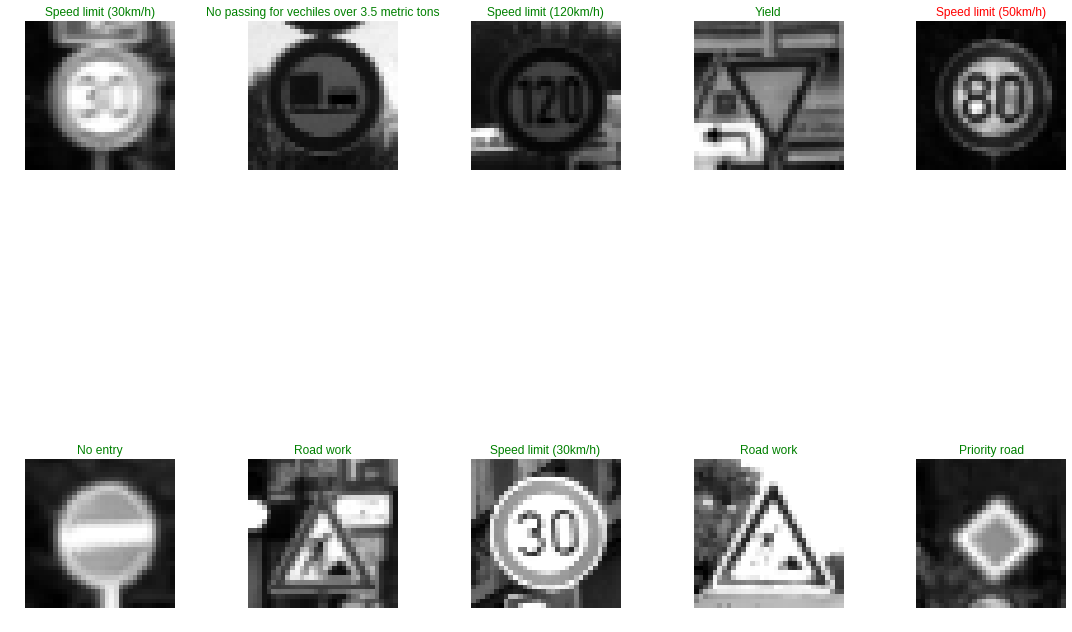

In [ ]:
# PLOT IMAGES WITH PREDICTED SIGNS

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

- In this case study, we want to classify images of traffic signs using deep Convolutional Neural Networks (CNNs).
- The dataset consists of 43 different classes of images. 
- Classes are as listed below: 
  - 0 = Speed limit (20km/h) 
  - 1 = Speed limit (30km/h)
  - 2 = Speed limit (50km/h) 
  - 3 = Speed limit (60km/h)
  - 4 = Speed limit (70km/h) 
  - 5 = Speed limit (80km/h)
  - 6 = End of speed limit (80km/h)
  - 7 = Speed limit (100km/h)
  - 8 = Speed limit (120km/h)
  - 9 = No passing
  - 10 = No passing for vehicles over 3.5 metric tons
  - 11 = Right-of-way at the next intersection
  - 12 = Priority road
  - 13 = Yield
  - 14 = Stop
  - 15 = No vehicles
  - 16 = Vehicles over 3.5 metric tons prohibited
  - 17 = No entry
  - 18 = General caution
  - 19 = Dangerous curve to the left
  - 20 = Dangerous curve to the right
  - 21 = Double curve
  - 22 = Bumpy road
  - 23 = Slippery road
  - 24 = Road narrows on the right
  - 25 = Road work
  - 26 = Traffic signals
  - 27 = Pedestrians
  - 28 = Children crossing 
  - 29 = Bicycles crossing
  - 30 = Beware of ice/snow
  - 31 = Wild animals crossing
  - 32 = End of all speed and passing limits
  - 33 = Turn right ahead
  - 34 = Turn left ahead
  - 35 = Ahead only
  - 36 = Go straight or right
  - 37 = Go straight or left
  - 38 = Keep right
  - 39 = Keep left
  - 40 = Roundabout mandatory
  - 41 = End of no passing
  - 42 = End of no passing by vehicles over 3.5 metric tons

- Citation
J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 
@inproceedings{Stallkamp-IJCNN-2011, author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel}, booktitle = {IEEE International Joint Conference on Neural Networks}, title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition}, year = {2011}, pages = {1453--1460} }